## Subsampling analysis

subsample the number of inidvidualas/RNA-seq datasets and look at how number of signals changes

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
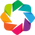

In [69]:
import pandas as pd
import numpy as np
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import ast

import holoviews as hv
hv.extension('bokeh')

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()


prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

I then run snakemake on each sumsample made with 'make_subsamples.ipynb' to get QTLs with config files in config/subsampling/


this next analysis assumes results in those folders

In [2]:
subsample_output_folder = f'{prefix}/config/subsampling_constant_clusters'

### Number QTLs across subsamples

In [3]:
# load in the configs for each 

subsample_nums = [100,200, 300]

sub_config = {}
for num_samples in subsample_nums:
    config_path= f'{subsample_output_folder}/{num_samples}_subsample.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        sub_config[num_samples] = config


tissue_ids = load_tissue_ids(config)
tissue_df = load_tissue_df(config)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


tissue_id = 'Cells_Cultured_fibroblasts'

In [4]:
# to load the random 100 (rather than 1st 100)
# for num_samples in [101]:
#     config_path= f'{prefix}/config/subsampling/{num_samples-1}_rand_subsample.yaml'
#     with open(config_path, 'r') as f:
#         config = yaml.safe_load(f)
#         sub_config[num_samples] = config

In [78]:
def get_qtl_counts(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    return overlap_df.groupby('orig_cs_dataset').count()['cs_full_id']


def get_cluster_count(tissue_id, config):
    cluster_df = pd.read_csv('{}/{}/{}_clusters_all_chr.csv'.format(prefix, config['clusters_dir'], tissue_id))
    return len(cluster_df)

def get_egene_count(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    if len(overlap_df) == 0:
        return 0
    else:
        return overlap_df['cluster_id'].nunique()
    
def get_permutation_eqtl_count(tissue_id, config):
    permutation_df = load_e_permutation(config, tissue_id)
    return len(permutation_df)

def get_permutation_pcqtl_count(tissue_id, config):
    permutation_df = load_pc_permutation(config, tissue_id)
    return len(permutation_df)

def get_permutation_egene_count(tissue_id, config):
    e_permutation_df = load_e_permutation(config, tissue_id)
    pc_permutation_df = load_pc_permutation(config, tissue_id)
    e_permutation_df['cluster_id'] = e_permutation_df['phenotype_id'].str.split('_e').str[0]
    pc_permutation_df['cluster_id'] = pc_permutation_df['phenotype_id'].str.split('_pc').str[0]

    return pd.concat([pc_permutation_df['cluster_id'], e_permutation_df['cluster_id']]).nunique()


def get_counts(config):
    counts = tissue_df['Tissue'].apply(get_qtl_counts, args=(config,))
    counts = tissue_df.join(counts)
    counts['clusters'] = counts['Tissue'].apply(get_cluster_count, args=(config,))
    counts['eclusters_susie'] = counts['Tissue'].apply(get_egene_count, args=(config,))
    try: 
        counts['eclusters_permutation'] = counts['Tissue'].apply(get_permutation_egene_count, args=(config,))
        counts['eqtl_permutaiton'] = counts['Tissue'].apply(get_permutation_eqtl_count, args=(config,))
        counts['pcqtl_permutaiton'] = counts['Tissue'].apply(get_permutation_pcqtl_count, args=(config,))
    except FileNotFoundError:
        print('no permutations')
        print(config)
    return counts

In [79]:
sub_counts = []
for num_samples in subsample_nums:
    sub_counts.append(get_counts(sub_config[num_samples]))

no permutations
{'tissue_id_path': 'data/references/test_tissue_ids.csv', 'covariates_dir': 'data/processed/subsampling/300/covariates/', 'expression_dir': 'data/processed/subsampling/300/normalized_expression/', 'chr_list_path': 'data/references/chrs.csv', 'genotype_stem': 'data/processed/genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01', 'filtered_expression_output_dir': 'output/subsampling_constant_clusters/300/clusters_expression/', 'clusters_dir': 'output/proteincoding_rewrite/clusters/', 'eqtl_output_dir': 'output/subsampling_constant_clusters/300/control_eqtl/', 'pcqtl_output_dir': 'output/subsampling_constant_clusters/300/pcqtl/', 'pc_output_dir': 'output/subsampling_constant_clusters/300/pcs/', 'overlap_output_dir': 'output/subsampling_constant_clusters/300/overlap/', 'annotations_output_dir': 'output/subsampling_constant_clusters/300/annotations/', 'percent_corr_cutoff': 0.7}


In [81]:
sub_counts

[                            Tissue  control_eqtl  pc_qtl  clusters  \
 0       Cells_Cultured_fibroblasts          3041    3055       861   
 1  Skin_Not_Sun_Exposed_Suprapubic          3024    3081       815   
 2                      Whole_Blood          3220    3249       883   
 
    eclusters_susie  eclusters_permutation  eqtl_permutaiton  pcqtl_permutaiton  
 0              861                    277               314                192  
 1              815                    124               130                 65  
 2              883                    154               169                 79  ,
                             Tissue  control_eqtl  pc_qtl  clusters  \
 0       Cells_Cultured_fibroblasts          1315    1183       861   
 1  Skin_Not_Sun_Exposed_Suprapubic           926     841       815   
 2                      Whole_Blood          1022     885       883   
 
    eclusters_susie  eclusters_permutation  eqtl_permutaiton  pcqtl_permutaiton  
 0              7

In [82]:
joined_count_df = pd.concat(sub_counts, keys=[*subsample_nums, 101], names=['num_samples', 'idx'])
joined_count_df.fillna(0, inplace=True)
joined_count_df.reset_index(level=0, inplace=True)
joined_counts = joined_count_df.melt(id_vars=['Tissue', 'num_samples'], var_name='count_type', value_name='count')

In [83]:
joined_counts

,Tissue,num_samples,count_type,count
0,Cells_Cultured_fibroblasts,100,control_eqtl,3041.0
1,Skin_Not_Sun_Exposed_Suprapubic,100,control_eqtl,3024.0
2,Whole_Blood,100,control_eqtl,3220.0
3,Cells_Cultured_fibroblasts,200,control_eqtl,1315.0
4,Skin_Not_Sun_Exposed_Suprapubic,200,control_eqtl,926.0
...,...,...,...,...
58,Skin_Not_Sun_Exposed_Suprapubic,200,pcqtl_permutaiton,964.0
59,Whole_Blood,200,pcqtl_permutaiton,957.0
60,Cells_Cultured_fibroblasts,300,pcqtl_permutaiton,0.0
61,Skin_Not_Sun_Exposed_Suprapubic,300,pcqtl_permutaiton,0.0


Text(0.5, 0.98, 'Subsampled counts')

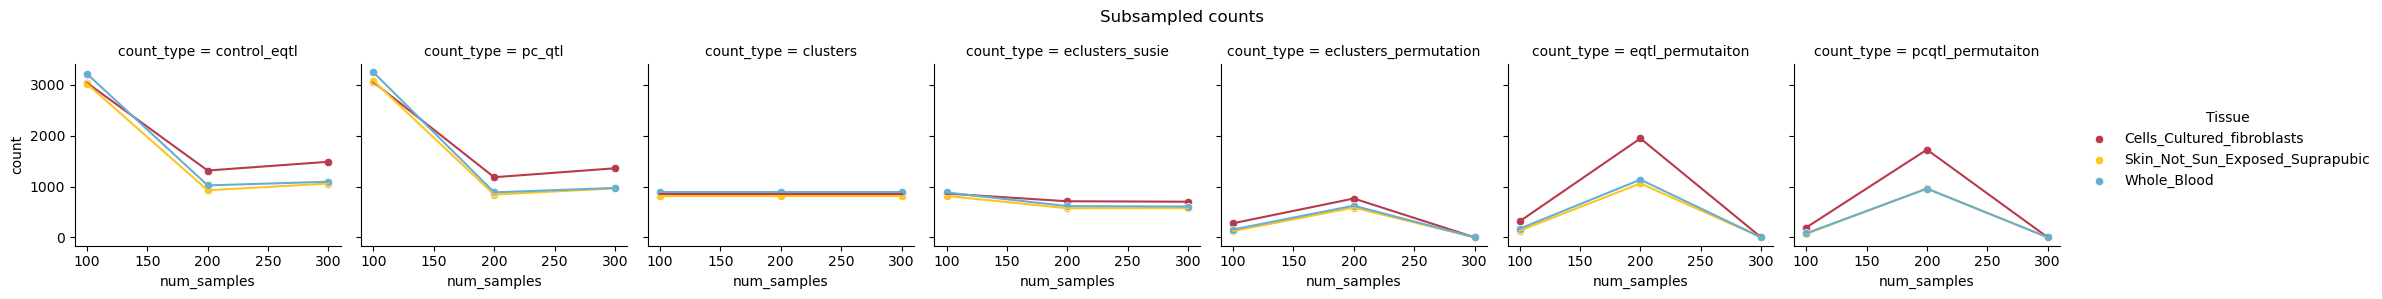

In [84]:
g = sns.FacetGrid(joined_counts, col="count_type", hue='Tissue', palette = tissue_pal)
g.map(sns.lineplot, "num_samples", "count")
g.map(sns.scatterplot, "num_samples", "count")
g.add_legend()
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Subsampled counts')

look at p values for each snp

In [59]:
sub_overlaps = {}
pc_nominals = {}
e_nominals = {}
for num_samples in subsample_nums:
    sub_overlaps[num_samples] = load_overlap(sub_config[num_samples], tissue_id)
    sub_overlaps[num_samples]['cs_size']=sub_overlaps[num_samples]['variant_list'].str.split(',').apply(len) 
    pc_nominals[num_samples] = load_pc_nominal(sub_config[num_samples], tissue_id, get_var_position=True)
    e_nominals[num_samples] = load_e_nominal(sub_config[num_samples], tissue_id, get_var_position=True)

In [10]:
e_nominals[100]['is_lead'] = e_nominals[100]['variant_id'].isin(sub_overlaps[100]['lead_variant_id'])
e_nominals[200]['is_lead'] = e_nominals[200]['variant_id'].isin(sub_overlaps[200]['lead_variant_id'])
e_nominal_merged = pd.merge(left=e_nominals[100], right=e_nominals[200],left_on=['phenotype_id', 'variant_id'], right_on=['phenotype_id', 'variant_id'], suffixes=['_100', '_200'])

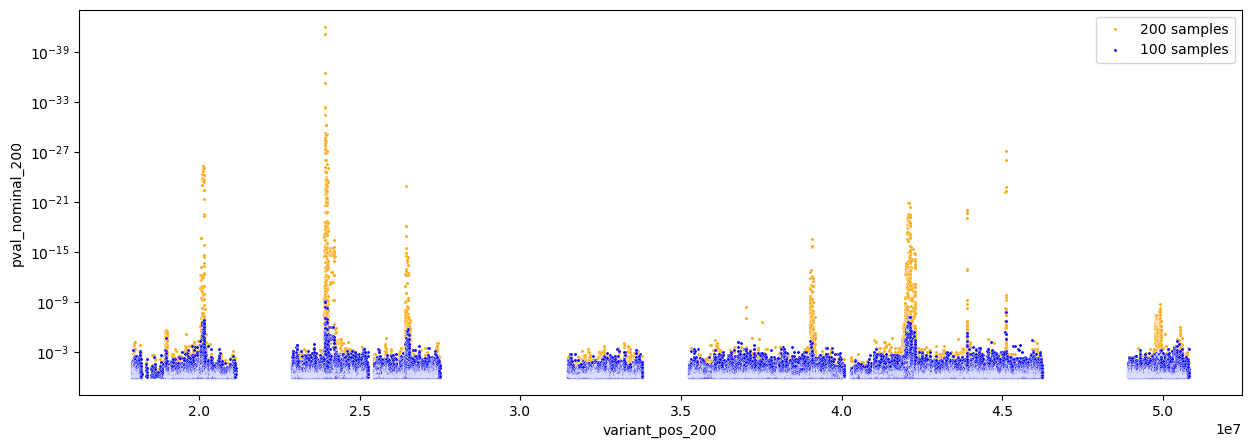

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(e_nominal_merged, y='pval_nominal_200', x='variant_pos_200', ax=ax, color='orange', s=5, label='200 samples')
sns.scatterplot(e_nominal_merged, y='pval_nominal_100', x='variant_pos_100', ax=ax, color='blue', s=5, label='100 samples')

ax.set_yscale('log')
ax.invert_yaxis()


In [41]:
cs_sizes={}
for num_samples in sub_overlaps.keys():
    cs_sizes[num_samples] = pd.Series(sub_overlaps[num_samples][(sub_overlaps[num_samples]['lead_variant_id'].str.contains('chr22'))&(sub_overlaps[num_samples]['orig_cs_dataset']=='control_eqtl')]['variant_list'].str.split(',').apply(len).values)

cs_sizes = pd.DataFrame(pd.concat(cs_sizes, names=['num_samples', 'idx']), columns=['cs_size'])

Text(0.5, 24.140625, 'credible set size')

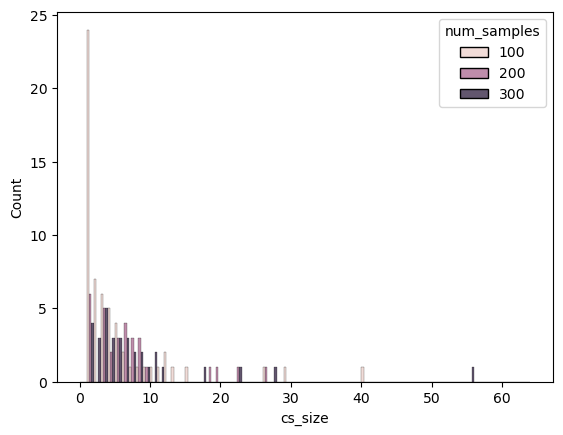

In [43]:
sns.histplot(x='cs_size', data=cs_sizes, hue='num_samples', multiple='dodge', bins=range(0, cs_sizes['cs_size'].max()))

ax.set_ylabel('Count')
ax.set_xlabel('credible set size')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
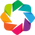

In [48]:
import holoviews as hv
hv.extension('bokeh')

In [49]:
# get the counts for unique lead vars 
subset_counts = up.query(up.from_contents({'100':sub_overlaps[100]['lead_variant_id'].unique(),
 '200':sub_overlaps[200]['lead_variant_id'].unique()})).subset_sizes

subset_counts = pd.DataFrame(subset_counts)

subset_counts['source'] = [('' if value else 'Not ') + 'QTL w/ 100' for value in subset_counts.index.get_level_values('100')]
subset_counts['target'] = [('' if value else 'Not ') + 'QTL w/ 200' for value in subset_counts.index.get_level_values('200')]

# sort the target and source to be QTLs on the bottom, not QTLs on the top 
subset_counts['source'] = pd.Categorical(subset_counts['source'], ["QTL w/ 100", "Not QTL w/ 100"])
subset_counts['target'] = pd.Categorical(subset_counts['target'], ["QTL w/ 200", "Not QTL w/ 200"])

subset_counts.sort_values(['source', 'target'], inplace=True)

sankey = hv.Sankey(subset_counts, label='Shared lead vars 100 vs 200 subsamples', vdims='size')
sankey.opts(label_position='left', edge_color='target', cmap='tab20')

:Sankey   [source,target]   (size)

In [ ]:
def get_cs_overlap(row, var_list):
    return sum(var_list.isin(row['variant_list_2'])) > 0

sub_overlaps[100]['variant_list_2'] = sub_overlaps[100]['variant_list'].apply(ast.literal_eval)
vars_100 = sub_overlaps[100]['variant_list_2'].explode()

sub_overlaps[200]['variant_list_2'] = sub_overlaps[200]['variant_list'].apply(ast.literal_eval)
vars_200 = sub_overlaps[200]['variant_list_2'].explode()

sub_overlaps[100]['200_overlap'] = sub_overlaps[100].progress_apply(get_cs_overlap, axis=1, args=(vars_200,))
sub_overlaps[200]['100_overlap'] = sub_overlaps[200].progress_apply(get_cs_overlap, axis=1, args=(vars_100,))

In [50]:
subset_counts.loc[(True,True), 'size'] = sum(sub_overlaps[100]['200_overlap'])
subset_counts.loc[(False,True), 'size'] = len(sub_overlaps[100]) - sum(sub_overlaps[100]['200_overlap'])
subset_counts.loc[(True,False), 'size'] = len(sub_overlaps[200]) - sum(sub_overlaps[200]['100_overlap'])

In [73]:
subset_counts = pd.DataFrame(subset_counts)

subset_counts['source'] = [('' if value else 'Not ') + 'part of cs w/ 100' for value in subset_counts.index.get_level_values('100')]
subset_counts['target'] = [('' if value else 'Not ') + 'part of cs w/ 200' for value in subset_counts.index.get_level_values('200')]

# sort the target and source to be QTLs on the bottom, not QTLs on the top 
subset_counts['source'] = pd.Categorical(subset_counts['source'], ["part of cs w/ 100", "Not part of cs w/ 100"])
subset_counts['target'] = pd.Categorical(subset_counts['target'], ["part of cs w/ 200", "Not part of cs w/ 200"])

subset_counts.sort_values(['source', 'target'], inplace=True)

sankey = hv.Sankey(subset_counts, label='Credible set overlap 100 vs 200 subsample', vdims='size')
sankey.opts(label_position='left', node_color='index', cmap='tab20')

:Sankey   [source,target]   (size)

<AxesSubplot: xlabel='cs_size', ylabel='Count'>

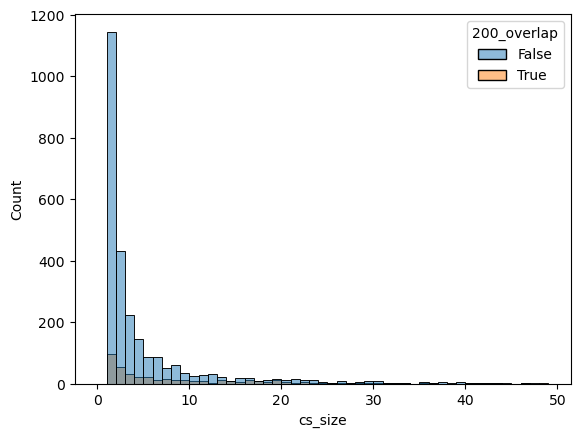

In [72]:
# color 100 vs 200 histogram by the above categories


sns.histplot(x='cs_size', data=sub_overlaps[100][(sub_overlaps[100]['orig_cs_dataset']=='control_eqtl')], hue='200_overlap', bins=range(0,50))